In [1]:
# 라이브러리를 불러옵니다.
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from matplotlib.colors import LogNorm
from matplotlib import rc
import seaborn as sns

import networkx as nx

In [2]:
# 한글 폰트 설정
font_path = '/usr/share/fonts/truetype/nanum/MalgunGothic.ttf'
fontprop = fm.FontProperties(fname=font_path, size=18)
rc('font', family='Malgun Gothic')

## 65세 이상 항우울제 미처방 환자 약물 네트워크 분석

In [19]:
# 데이터를 불러옵니다.
data_senior = pd.read_csv('./data/prescription_over_65_comor_sample_2021.csv')

comor_mapping = pd.read_csv('data/mapping/comorbidities_mapping.csv', encoding='utf-8')

In [20]:
# 데이터의 첫 다섯 줄을 출력합니다.
print(data_senior.shape)
data_senior.head()

(201593, 16)


,기준년도,가입자일련번호,처방내역일련번호,일련번호,성별코드,연령대코드(5세단위),시도코드,요양개시일자,약품일반성분명코드,1회 투약량,1일투약량,총투여일수,단가,금액,데이터 공개일자,ATC코드
0,2021,403017,154510,1,2,14,41,2021-12-21,111001ATE,1.0,1,30,77.0,2310,2022-08-11,B01AC06
1,2021,547179,238048,1,2,16,41,2021-05-26,111001ATE,1.0,1,30,77.0,2310,2022-08-11,B01AC06
2,2021,287268,320180,1,1,15,41,2021-11-12,111001ATE,1.0,1,30,77.0,2310,2022-08-11,B01AC06
3,2021,403017,320961,1,2,14,41,2021-05-21,111001ATE,1.0,1,30,77.0,2310,2022-08-11,B01AC06
4,2021,547179,461888,1,2,16,41,2021-10-26,111001ATE,1.0,1,30,77.0,2310,2022-08-11,B01AC06


---

In [21]:
# 컬럼 이름들을 영문으로 바꿔줍니다
df_senior = data_senior.rename(columns={
    '기준년도': 'year',
    '가입자일련번호': 'user_id',
    '처방내역일련번호': 'pres_id',
    '일련번호': 'med_id',
    '성별코드': 'gender',
    '연령대코드(5세단위)': 'age_group',
    '시도코드': 'region',
    '요양개시일자': 'start_date',
    '약품일반성분명코드': 'mi_code',
    '1회 투약량': 'dose_per_time',
    '1일투약량': 'dose_per_day',
    '총투여일수': 'total_days',
    '단가': 'unit_price',
    '금액': 'total_price',
    '데이터 공개일자': 'data_release_date',
    'ATC코드': 'ATC_code'
})

In [22]:
# 한 환자당 처방전의 개수를 세어봅니다.
print(f"고려되는 총 환자 수: {df_senior['user_id'].nunique()}")
df_senior.groupby('user_id')['pres_id'].count().describe()

고려되는 총 환자 수: 12164


count    12164.000000
mean        16.572920
std         15.689849
min          1.000000
25%          5.000000
50%         12.000000
75%         23.000000
max        175.000000
Name: pres_id, dtype: float64

#### 각 나이대별 처방전은 몇개의 약물을 포함하고 있을까?

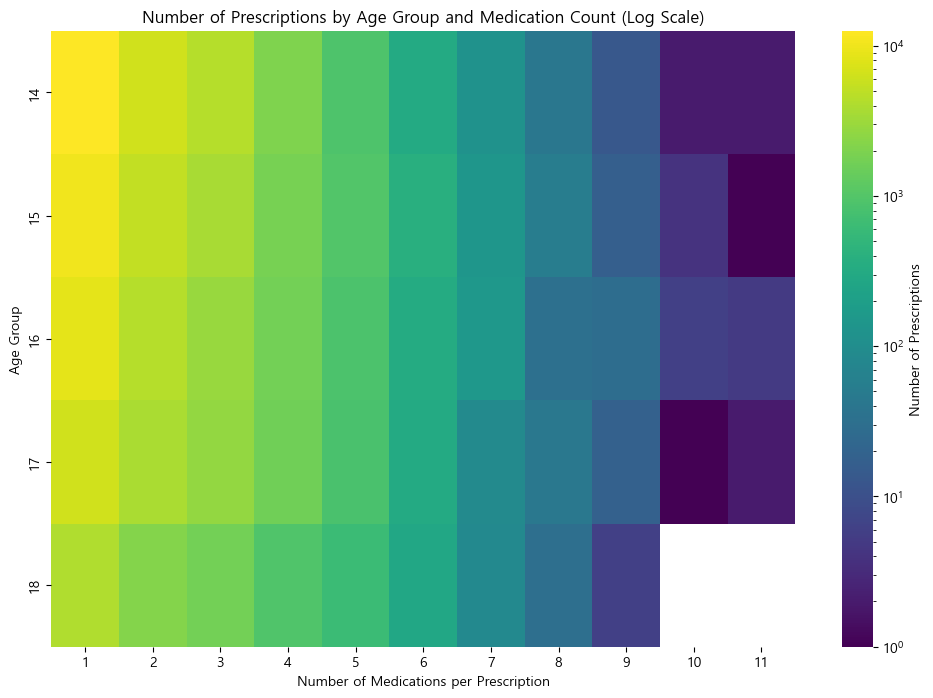

In [23]:
# Step 1: Calculate the number of medications per prescription for each age group
grouped = df_senior.groupby(['age_group', 'pres_id'])['ATC_code'].count().reset_index()
grouped.rename(columns={'ATC_code': 'cnt_med'}, inplace=True)

# Step 2: Count the number of prescriptions for each age group and medication count
counts = grouped.groupby(['age_group', 'cnt_med']).size().reset_index(name='cnt_pres')

# Step 3: Pivot the data to create a matrix suitable for a heatmap
pivot_table = counts.pivot(index='age_group', columns='cnt_med', values='cnt_pres').fillna(0)

# Step 4: Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(pivot_table, norm=LogNorm(), cmap='viridis', cbar_kws={'label': 'Number of Prescriptions'})
plt.xlabel('Number of Medications per Prescription')
plt.ylabel('Age Group')
plt.title('Number of Prescriptions by Age Group and Medication Count (Log Scale)')
plt.show()

처방전 별 평균 약품 수는 연령대 그룹이 올라갈수록 높아지는 트렌드를 보여주고 있습니다.

그러나 많은 처방전들이 1~4 사이의 약품을 처방한다는 것을 확인할 수 있습니다.

한 사람당 여러번의 처방전이 발부될 수 있고 (max 30개), 그 처방전들 중 같은 약을 포함하기도하고 다른 약을 포함하기도 한다는 것을 볼 수 있습니다.

두 종류의 약물이 같이 처방된 빈도 수를 계산할 때, 같은 사람에게 여러번 처방된 케이스는 같이 처방된 횟수로 나누어야 한다고 판단했습니다.

그렇지 않으면 한사람에게 여러번 처방된 약들이 weight에 불평등한 영향을 미칠 것으로 예상됩니다.

---

### 65세 이상 그래프 생성

In [24]:
# 그래프를 생성하는 함수를 만듭니다.
def create_graph(data):
    G = nx.Graph()
    
    # 노드를 추가합니다.
    for atc_code in data['ATC_code'].unique():
        G.add_node(atc_code)
        
    # user_id와 pres_id로 그룹화하여 동시 발생을 찾습니다.
    user_cooccurrences = {}
    for user_id, user_group in data.groupby('user_id'):
        # 각 user_id에 대해 co-occurrence를 집합으로 저장합니다.
        cooccurrences = set()
        for pres_id, pres_group in user_group.groupby('pres_id'):
            atc_codes = pres_group['ATC_code'].unique()
            for i in range(len(atc_codes)):
                for j in range(i + 1, len(atc_codes)):
                    cooccurrence = tuple(sorted((atc_codes[i], atc_codes[j])))
                    cooccurrences.add(cooccurrence)
        user_cooccurrences[user_id] = cooccurrences

    # co-occurrence를 그래프에 추가합니다.
    for cooccurrences in user_cooccurrences.values():
        for atc_code1, atc_code2 in cooccurrences:
            if G.has_edge(atc_code1, atc_code2):
                G[atc_code1][atc_code2]['weight'] += 1
            else:
                G.add_edge(atc_code1, atc_code2, weight=1)

    return G

In [25]:
# 그래프를 생성합니다.
G_senior = create_graph(df_senior)

# 그래프의 노드와 엣지 수를 출력합니다.
print(f"Number of nodes: {G_senior.number_of_nodes()}")
print(f"Number of edges: {G_senior.number_of_edges()}")

Number of nodes: 197
Number of edges: 4672


In [27]:
# ATC 코드를 약품명으로 바꿔줍니다.
atc_to_name = comor_mapping.set_index('ATC코드')['주성분명'].to_dict()

# 만성질환 질병 종류를 구분해줍니다.
class_map = comor_mapping[['ATC코드', 'comorbidity_class']].drop_duplicates(subset=['ATC코드'], keep='first')
atc_to_class = class_map.set_index('ATC코드')['comorbidity_class'].to_dict()

# 그래프에 label을 추가합니다.
for node in G_senior.nodes:
    G_senior.nodes[node]['label'] = atc_to_name[node]
    G_senior.nodes[node]['comorbidity'] = atc_to_class[node]

In [28]:
# Gephi로 시각화를 위해 그래프를 저장합니다.
nx.write_gexf(G_senior, './data/gephi/no_depression_65_prescription_network.gexf')

---
## 10대 항우울제 미처방 환자 약물 네트워크 분석

In [37]:
# 데이터를 불러옵니다.
data_teens = pd.read_csv('./data/prescription_teens_comor_sample_2021.csv')

In [39]:
# 데이터의 첫 다섯 줄을 출력합니다.
print(data_teens.shape)
data_teens.head()

(737, 16)


,기준년도,가입자일련번호,처방내역일련번호,일련번호,성별코드,연령대코드(5세단위),시도코드,요양개시일자,약품일반성분명코드,1회 투약량,1일투약량,총투여일수,단가,금액,데이터 공개일자,ATC코드
0,2021,885620,943972,1,2,3,41,2021-10-19,374601ATB,1.0,1,5,774.0,3870,2022-08-11,R03DC03
1,2021,975788,1869799,1,1,3,41,2021-09-25,374601ATB,1.0,1,4,774.0,3096,2022-08-11,R03DC03
2,2021,775551,432248,1,2,4,41,2021-09-12,216408ATB,1.0,1,3,526.0,1578,2022-08-11,R03DC02
3,2021,987412,482369,1,1,3,41,2021-10-16,670600ATB,1.0,1,4,886.0,3544,2022-08-11,R03DC53
4,2021,910159,3675831,1,1,3,48,2021-02-24,374601ATB,1.0,1,3,774.0,2322,2022-08-11,R03DC03


In [40]:
# 컬럼 이름들을 영문으로 바꿔줍니다
df_teens = data_teens.rename(columns={
    '기준년도': 'year',
    '가입자일련번호': 'user_id',
    '처방내역일련번호': 'pres_id',
    '일련번호': 'med_id',
    '성별코드': 'gender',
    '연령대코드(5세단위)': 'age_group',
    '시도코드': 'region',
    '요양개시일자': 'start_date',
    '약품일반성분명코드': 'mi_code',
    '1회 투약량': 'dose_per_time',
    '1일투약량': 'dose_per_day',
    '총투여일수': 'total_days',
    '단가': 'unit_price',
    '금액': 'total_price',
    '데이터 공개일자': 'data_release_date',
    'ATC코드': 'ATC_code'
})

In [41]:
# 한 환자당 처방전의 개수를 세어봅니다.
print(f"고려되는 총 환자 수: {df_teens['user_id'].nunique()}")
df_teens.groupby('user_id')['pres_id'].count().describe()

고려되는 총 환자 수: 246


count    246.000000
mean       2.995935
std        3.173227
min        1.000000
25%        1.000000
50%        2.000000
75%        4.000000
max       32.000000
Name: pres_id, dtype: float64

---
### 십대 그래프 생성

In [42]:
# 그래프를 생성합니다.
G_teens = create_graph(df_teens)

# 그래프의 노드와 엣지 수를 출력합니다.
print(f"Number of nodes: {G_teens.number_of_nodes()}")
print(f"Number of edges: {G_teens.number_of_edges()}")

Number of nodes: 24
Number of edges: 26


In [43]:
# ATC 코드를 약품명으로 바꿔줍니다.
atc_to_name = comor_mapping.set_index('ATC코드')['주성분명'].to_dict()

# 만성질환 질병 종류를 구분해줍니다.
class_map = comor_mapping[['ATC코드', 'comorbidity_class']].drop_duplicates(subset=['ATC코드'], keep='first')
atc_to_class = class_map.set_index('ATC코드')['comorbidity_class'].to_dict()

# 그래프에 label을 추가합니다.
for node in G_teens.nodes:
    G_teens.nodes[node]['label'] = atc_to_name[node]
    G_teens.nodes[node]['comorbidity'] = atc_to_class[node]

In [ ]:
# Gephi로 시각화를 위해 그래프를 저장합니다.
nx.write_gexf(G_teens, './data/gephi/no_depression_teens_prescription_network.gexf')

---
## 중년 항우울제 미처방 환자 약물 네트워크 분석

In [45]:
# 데이터를 불러옵니다.
data_middle_aged = pd.read_csv('./data/prescription_middle_aged_comor_sample_2021.csv')

In [46]:
# 데이터의 첫 다섯 줄을 출력합니다.
print(data_middle_aged.shape)
data_middle_aged.head()

(159273, 16)


,기준년도,가입자일련번호,처방내역일련번호,일련번호,성별코드,연령대코드(5세단위),시도코드,요양개시일자,약품일반성분명코드,1회 투약량,1일투약량,총투여일수,단가,금액,데이터 공개일자,ATC코드
0,2021,274337,81154,1,1,9,41,2021-04-05,111001ATE,1.0,1,30,77.0,2310,2022-08-11,B01AC06
1,2021,500572,180077,1,1,10,41,2021-09-09,111001ATE,1.0,1,30,77.0,2310,2022-08-11,B01AC06
2,2021,836410,194111,1,1,12,41,2021-10-19,111001ATE,1.0,1,30,77.0,2310,2022-08-11,B01AC06
3,2021,500572,343036,1,1,10,41,2021-12-07,111001ATE,1.0,1,30,77.0,2310,2022-08-11,B01AC06
4,2021,683056,348222,1,1,10,41,2021-07-07,111001ATE,1.0,1,30,77.0,2310,2022-08-11,B01AC06


In [47]:
# 컬럼 이름들을 영문으로 바꿔줍니다
df_middle_aged = data_middle_aged.rename(columns={
    '기준년도': 'year',
    '가입자일련번호': 'user_id',
    '처방내역일련번호': 'pres_id',
    '일련번호': 'med_id',
    '성별코드': 'gender',
    '연령대코드(5세단위)': 'age_group',
    '시도코드': 'region',
    '요양개시일자': 'start_date',
    '약품일반성분명코드': 'mi_code',
    '1회 투약량': 'dose_per_time',
    '1일투약량': 'dose_per_day',
    '총투여일수': 'total_days',
    '단가': 'unit_price',
    '금액': 'total_price',
    '데이터 공개일자': 'data_release_date',
    'ATC코드': 'ATC_code'
})

In [48]:
# 한 환자당 처방전의 개수를 세어봅니다.
print(f"고려되는 총 환자 수: {df_middle_aged['user_id'].nunique()}")
df_middle_aged.groupby('user_id')['pres_id'].count().describe()

고려되는 총 환자 수: 21110


count    21110.000000
mean         7.544908
std         10.064882
min          1.000000
25%          1.000000
50%          4.000000
75%         10.000000
max        244.000000
Name: pres_id, dtype: float64

### 중년층 그래프 생성

In [49]:
# 그래프를 생성합니다.
G_middle_aged = create_graph(df_middle_aged)

# 그래프의 노드와 엣지 수를 출력합니다.
print(f"Number of nodes: {G_middle_aged.number_of_nodes()}")
print(f"Number of edges: {G_middle_aged.number_of_edges()}")

Number of nodes: 190
Number of edges: 3113


In [50]:
# ATC 코드를 약품명으로 바꿔줍니다.
atc_to_name = comor_mapping.set_index('ATC코드')['주성분명'].to_dict()

# 만성질환 질병 종류를 구분해줍니다.
class_map = comor_mapping[['ATC코드', 'comorbidity_class']].drop_duplicates(subset=['ATC코드'], keep='first')
atc_to_class = class_map.set_index('ATC코드')['comorbidity_class'].to_dict()

# 그래프에 label을 추가합니다.
for node in G_middle_aged.nodes:
    G_middle_aged.nodes[node]['label'] = atc_to_name[node]
    G_middle_aged.nodes[node]['comorbidity'] = atc_to_class[node]

In [51]:
# Gephi로 시각화를 위해 그래프를 저장합니다.
nx.write_gexf(G_middle_aged, './data/gephi/no_depression_middle_aged_prescription_network.gexf')